In [4]:
import numpy as np
import torch
import sys
sys.path.insert(0, '../')
from models.fft_utils import *
import matplotlib.pyplot as plt
%matplotlib inline
from data.ft_data_loader import ft_data_loader
from util import util
from torchvision.utils import make_grid
import time
which_dataset = 'KNEE'
testloader = ft_data_loader.get_test_loader(batch_size=64,
                                            load_size=144,
                                            fine_size=128,
                                            keep_ratio=0.25,
                                            shuffle=True,
                                            num_workers=4,
                                            pin_memory=True,
                                            normalize='zero_one',
                                            which_dataset=which_dataset)

def gen_kspace_mask(shape, ratio=0.25, mask_low_freqs = 5, seed=42):
    
    h, w = shape
    mask_fft = (np.random.RandomState(seed).rand(h) < ratio).astype(np.float32)
    mask_fft[:mask_low_freqs] = mask_fft[-mask_low_freqs:] = 1
    mask_fft = torch.from_numpy(mask_fft).view(1, 1, h, 1)

    return mask_fft
RFFT = RFFT().to(0)
IFFT = IFFT().to(0)
IRFFT = IRFFT().to(0)
FFT = FFT().to(0)
mask = gen_kspace_mask((128,128),ratio=0.17)
mask2 = gen_kspace_mask((128,128),ratio=0.2)

iter_loader = iter(testloader)
img = iter_loader.next()[1][40:41]

masks = torch.cat([gen_kspace_mask((128,128),seed=np.random.randint(0,10000)) for _ in range(10)],0)
plt.imshow(mask.expand(1,1,128,128)[0,0], cmap='jet')
plt.axis('off')

load KNEE test dataset


ModuleNotFoundError: No module named 'common'

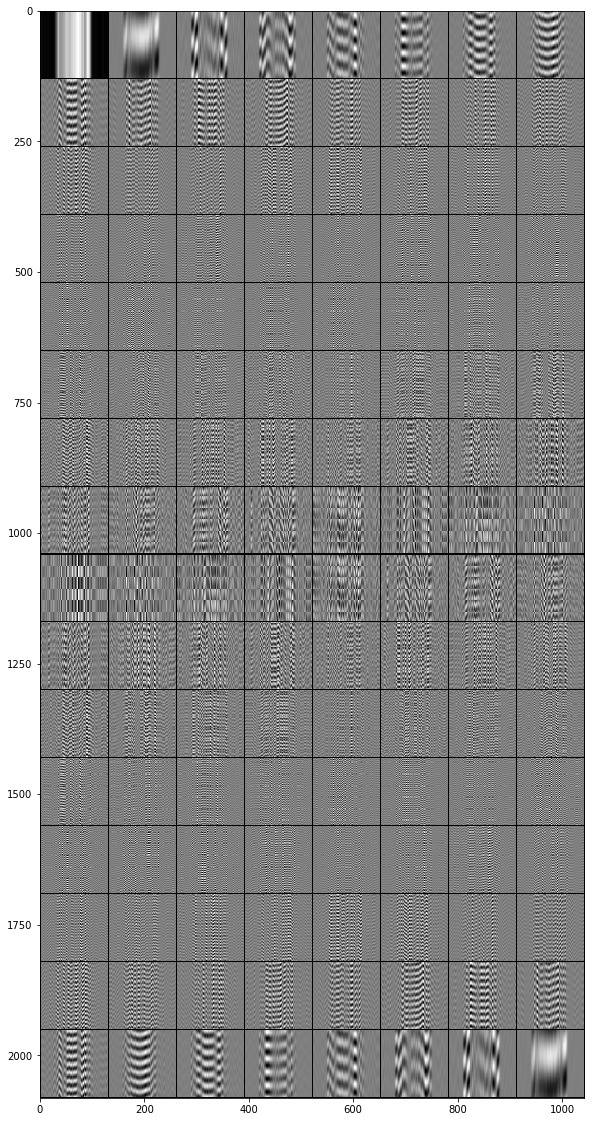

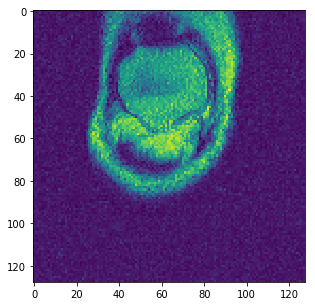

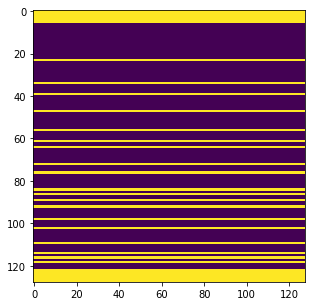

In [5]:
img = iter_loader.next()[1][30:40]
kspace = RFFT(img)

seperate_kspace = kspace.unsqueeze(1).repeat(1,128,1,1,1)
seperate_mask = torch.zeros_like(masks).repeat(1,128,1,1).unsqueeze(2)
bz = masks.shape[0]

# for i in range(bz):
# #     idx = torch.nonzero(masks[i,0,:,0])
# #     assert idx.shape[0] == mask.sum().item()
#     seperate_mask[i,idx,:,idx,:] = 1 # [1,imsize,1,imsize,1]
#     import pdb; pdb.set_trace()
# #     if i < 10:
# #         plt.figure()
# #         plt.imshow(seperate_mask[i,])

for i in range(128):
    seperate_mask[:,i,:,i,:] = 1 # [1,imsize,1,imsize,1]
#     import pdb; pdb.set_trace()

masked_kspace = seperate_mask * seperate_kspace
masked_kspace = masked_kspace.view(1280,2,128,128)
I = IFFT(masked_kspace)[:,0,:,:].view(10,128,128,128)

ID = 2
I = I[ID,:,:,:].view(128,1,128,128)
## test
for i in range(128):
    if masks[ID].view(-1)[i] == 0:
        assert I[i].sum() == 0

mask = masks[ID][0].repeat(1,128)

# print(masks[ID])
I2 = util.mri_denormalize(I.mul(1))
vis_img = make_grid(I2).permute(1,2,0)
plt.figure(figsize=(20,20))
plt.imshow(vis_img)
plt.figure(figsize=(5,5))
plt.imshow(I.mean(0)[0])
plt.figure(figsize=(5,5))   
plt.imshow(mask)

time cost 0.057352542877197266


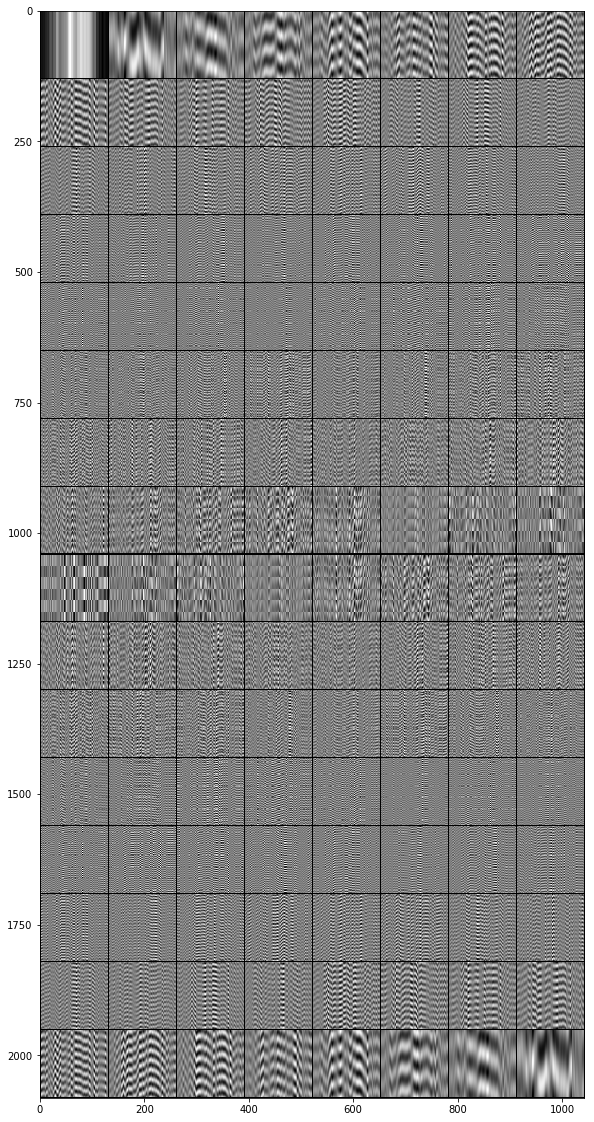

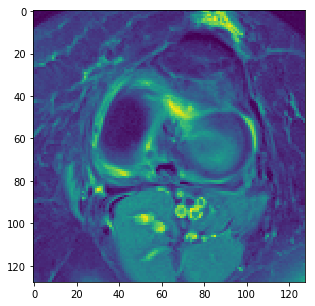

In [8]:
# def seperate_kspace_channel(img):

kspace = RFFT(img)
k = torch.ones(1,1,128,1)
t = k.sum()
st = time.time()

## loop way
# imgs = []
# wind = 1
# for i in range(128//wind):
#     _k = k.mul(1)
# #     print(range(i*wind,(i+1)*wind))
#     _k[:,:,i*wind:(i+1)*wind,:] = 1
#     masked_kspace = kspace * _k
#     imgs.append(IFFT(masked_kspace)[:,:1,:,:])
# I = torch.cat(imgs,0)

## faster way
seperate_mask = torch.zeros(1,128,1,128,1)
idx = torch.nonzero(k[0,0,:,0])
assert idx.shape[0] == t.item()
seperate_mask[:,idx,:,idx,:] = 1
kspace = kspace.view(1,1,2,128,128).repeat(1,128,1,1,1)
masked_kspace = seperate_mask * kspace
masked_kspace = masked_kspace.view(128,2,128,128)
I = IFFT(masked_kspace)[:,:1,:,:]
end = time.time()

print('time cost', end-st)
I2 = util.mri_denormalize(I.mul(1))
vis_img = make_grid(I2).permute(1,2,0)
plt.figure(figsize=(20,20))
plt.imshow(vis_img)
plt.figure(figsize=(5,5))
plt.imshow(I.mean(0)[0])
    

In [44]:
conv = nn.Conv2d(128,32,1,1,padding=1,groups=1)
conv2 = nn.Conv2d(32,1,1,1,padding=1,groups=1)
h = conv(I.transpose(0,1))
out = conv2(h)
print(out.shape)
print(conv.weight.data.shape)
print(conv2.weight.data.shape)


torch.Size([1, 1, 132, 132])
torch.Size([32, 128, 1, 1])
torch.Size([1, 32, 1, 1])


In [ ]:
yGrad = torch.zeros(1,1)
def extract(xVar):
    global yGrad
    yGrad = xVar
    print(yGrad)

out.register_hook(extract)

out = out.norm(2)
out.backward()

NameError: name 'plt' is not defined